# Inverse kinematics
This notebook considers the problem of inverse kinematics, ie solving at each control cycle of the robot a quadratic program from the derivatives (jacobian) of the current state. It introduces the basic function to compute the Jacobians of the robot, and how to use them to compute an inverse-kinematics control law. One of the key difficulties is to understand in which frames each quantities is computed (might be in the world frame, in the local frame attached to the end effector, in some arbitrary goal frame, etc), as we should never mixed quantities expressed in different frames without transporting them in the right frame. 


In [2]:
import magic_donotload  # noqa: F401

## Set up
We will MeshCat for visualization and NumPy for linear algebra. Note that the [@ operator](https://numpy.org/doc/stable/reference/routines.linalg.html#the-operator) is a way to compute the matrix (dot) product between two NumPy arrays, similar to ``np.dot(A, B)``.

In [3]:
import pinocchio as pin
import numpy as np
import time
from numpy.linalg import pinv,inv,norm,svd,eig
from tp3.tiago_loader import loadTiago
import matplotlib.pylab as plt; plt.ion()
from utils.meshcat_viewer_wrapper import MeshcatVisualizer

We will use the [Tiago](https://youtu.be/6BwRqwD066g) robot, a mobile manipulator from PAL Robotics:

In [5]:
robot = loadTiago()
viz = MeshcatVisualizer(robot)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7005/static/


Tiago consists of:

- A mobile base that can move in the plane (the corresponding joint will be a *floating base* in $SE(2)$, thus with three degrees of freedom).
- A manipulator arm (seven DOFs).
- An articulated head (two DOFs).
- A prismatic axis moving vertically (one DOF), on which arm and head are mounted.
- Two extra joints to represent the wheels under the mobile base (two DOFs), which we won't use in this tutorial.

The wheel and the base rotations are represented by the vector $[\cos \theta\ \sin \theta]$ corresponding to their angle $\theta$. This choice of representation results in a larger vector, subject to the constraint $\cos(\theta)^2 + \sin(\theta)^2 = 1$, but with no discontinuity at the boundary of the angular interval chosen to select a unique angle. The dimension of the configuration space (equivalently, the size of the configuration vector) is then:

| Joint          | DOFs | Dim. of config. repr. | Dim. of tangent repr. |
|----------------|------|-----------------------|-----------------------|
| Mobile base    | 3    | 4  | 3 |
| Manipulator    | 7    | 7  | 7 |
| Head           | 2    | 2  | 2 |
| Prismatic axis | 1    | 1  | 1 |
| Wheels         | 2    | 4  | 2 |
| **Total**      | **15** | **18** | **15** |

You can check these values in ``robot.model.nq`` and ``robot.model.nv``.

The configuration is represented by a vector of larger dimension, subject to constraints $\cos(\theta)^2 + \sin(\theta)^2 = 1$. It is not possible to randomly sample a configuration vector $q$ using the distributions from NumPy, as the results won't respect these constraints. Similarly, we should take care when integrating velocities, as summing a configuration $q$ with a velocity $v$ is undefined (dimensions don't match). Two functions in Pinocchio implements these functionnalities.

In [6]:
q = pin.randomConfiguration(robot.model)
vq = np.random.rand(robot.model.nv)*2 - 1
DT = 1e-3
qnext = pin.integrate(robot.model,q,vq*DT)

Here is a simple example where we move the robot in the viewer following a constant (random) velocity:

In [7]:
for t in range(1000):
    q = pin.integrate(robot.model,q,vq*DT)
    viz.display(q)
    time.sleep(DT/10)

The robot is mobile, hence the camera view in the viewer is not always centered. Also, don't worry if you see the torso fly above the prismatic joint: we are not including joint limits yet 😉

## Forward kinematics and Jacobian

Here's a quick recap on forward kinematics. Let's consider two frames of interest: the first one, named "frametool" is at the tip of the end-effector; the second one, named "framebasis", is at the fore of the robot's mobile base, 10 cm above the ground. Both are represented in MeshCat by a triad of RGB arrows:

In [8]:
IDX_TOOL = robot.model.getFrameId('frametool')
IDX_BASIS = robot.model.getFrameId('framebasis')

In [9]:
robot.model.frames[IDX_TOOL]

Frame name: frametool paired to (parent joint/ previous frame)(9/52)
with relative placement wrt parent joint:
  R =
1 0 0
0 1 0
0 0 1
  p =    0    0 0.08
containing inertia:
  m = 0
  c = 0 0 0
  I = 
0 0 0
0 0 0
0 0 0

The `frames` vector in a `robot.model` contains relative placements in $SE(3)$: ``frames[i]`` gives the placement from frame $i$ to its parent frame in the kinematic tree. If the frame is that of a link rather than a joint, it will also contain non-zero inertias.

### Computing frame placement

The global placement of the frames is computed by the Pinocchio function `framesForwardKinematics`, whose results are stored in `robot.data.oMf`. Read `oMf` as ${}^0 M_f$, where $0$ is the index of our inertial frame (*a.k.a.* the world frame).

In [10]:
pin.framesForwardKinematics(robot.model, robot.data, q)

oMtool = robot.data.oMf[IDX_TOOL]
oMbasis = robot.data.oMf[IDX_BASIS]

print("Tool placement:",oMtool)
print("Basis placement:",oMbasis)

Tool placement:   R =
-0.359761   -0.8039 -0.473621
 0.895704 -0.439726 0.0659926
-0.261315 -0.400483  0.878253
  p = -0.654046   1.44758  0.486462

Basis placement:   R =
0.0921162 -0.995748         0
 0.995748 0.0921162         0
        0         0         1
  p = -0.417443   1.59017      0.15



It is important to note the instruction pattern, which is standard in all Pinocchion functions: first, call an algorithm (here ``pin.framesForwardKinematics``); then, access the results in *robot.data*. Our `robot.model` contains the abstract structure (the model) of our robot, whereas `robot.data` contains a particular instance of that structure, populated by the algorithm for a given instance of configuration, velocity, etc.

The tool-placement matrix $^0M_{tool}$ represents the displacement between the tool frame $F_{tool}$ and the world frame $F_{world}$. It is the affine transform matrix that maps vectors expressed in $F_{tool}$ to their corresponding vectors expressed in $F_0$. It consists of a $3 \times 3$ rotation matrix $^0 R_{tool}$, and a 3D position vector:

$$
^0T_{tool} = {}^0 (p_{tool} - p_{0}) = {}^0 p_{tool} - {}^0 p_{0} = {}^0 p_{tool}.
$$

This is the vector from the origin of frame $F_0$ to the origin of frame $F_{tool}$, expressed in the world frame $F_0$. We can also express $p_{tool} - p_{0}$ in the tool frame $F_{tool}$ by multiplying $^0T_{tool}$ by ${}^{tool} R _0 = {}^{0}R_{tool}^T$:

$$
{}^{tool} (p_{tool} - p_0) = - {}^{tool}p_0 = R_0 {}^0 T_{tool}.
$$

Take care with the multiplication operator in NumPy: the operator ``*`` is (unintuitively) mapped to the coefficient-wise multiplication (*a.k.a.* the [Hadamard product](Hadamard product)), that is, **not** the usual matrix multiplication. You should use the operator ``@`` to get an actual matrix-to-matrix dot product. (Or never mind: you will likely be tricked at least once by this, then remember it out of spite 😅) 

### Computing Jacobians
The Jacobian of a frame of the robot is computed using `pin.computeFrameJacobian`:

In [11]:
Jtool = pin.computeFrameJacobian(robot.model, robot.data, q, IDX_TOOL)
Jtool.shape

(6, 15)

This matrix has 6 rows and ``robot.model.nv == 15`` columns. It corresponds to the "body" 6D velocity of the end effector, that is, vectors in the image of this Jacobian matrix are expressed in $F_{tool}$ rather than in $F_0$. Let's first focus on the first three rows. Those correspond to the linear velocity of the tool frame, in the tool frame:

In [12]:
Jtool3 = Jtool[:3,:]

#### Jacobian as a velocity operator
A first way to understand what is this matrix is to see that as an operator that converts the velocity in the configuration space to the linear velocity of the tool:

In [13]:
vtool = Jtool3 @ vq

But in which frame is $v_{tool}$ expressed? The choice in Pinocchio (following the principles described in [Rigid body dynamics algorithms](https://doi.org/10.1007/978-1-4899-7560-7)) is to express quantities in the local frame by default. Therefore, ``vtool`` here is ${}^{tool} v_{tool}$, expressed in the tool frame $F_{tool}$. We can compute the velocity in the world frame $F_0$ by applying the rotation matrix $^{0}R_{tool}$:

In [14]:
tool_vtool = vtool
o_vtool = oMtool.rotation @ vtool

The resulting velocity, that we denote by ${}^0 v_{tool}$ here, is ${}^{tool} v_{tool}$ rotated to the world frame.

In [15]:
tool_Jtool = pin.computeFrameJacobian(robot.model, robot.data, q, IDX_TOOL, pin.LOCAL)
tool_Jtool3 = tool_Jtool[:3,:]

We are using long variable names here to keep track. (A common practice is to only shorten these variable names when their full meaning is clear from context.) We can generalize this notation to the Jacobian part dedidcated to linear velocity expressed in the world frame $F_0$:

In [16]:
o_Jtool3 = oMtool.rotation @ tool_Jtool3

To be more precise, the relation between Jacobian, motion and frame is:
$$
^{tool}J_{tool} \dot{q} = ^{tool}\xi_{tool} = \begin{bmatrix} ^{tool}v_{tool} \\ ^{tool}\omega_{tool} \end{bmatrix}
$$
Here ${}^{tool} \xi_{tool}$ is the *twist* (the instantaneous rigid-body motion, including both linear and angular velocity) from frame $F_{tool}$ to frame $F_0$, expressed in $F_{tool}$ itself. Mathematically, twist is just a name for any element of the Lie algebra $\mathfrak{se}(3)$. We can interpret $^{tool}v_{tool}$ as the point velocity of the origin of frame $F_{tool}$, expressed in itself, and $^{tool}\omega_{tool}$ as the instaneous rotation axis/amplitude.

#### Adjoint operator

We can also compute the twist ${}^0 w_{tool}$ in the world frame. Its formula is given by:
$$
{}^{0}\xi_{tool} = {}^{0}J_{tool}\dot{q} = {}^{0}X_{tool}{}^{tool}\xi_{tool} = ({}^{0}X_{tool}{}^{tool}J_{tool}) \dot{q}
$$
where $^{0}X_{tool}$ is the *adjoint operator* related to $[{}^{0}R_{tool}, {}^{0}T_{tool}]$ that allows us to change frame for elements of $\mathfrak{se}(3)$.
It express:
$$
{}^{0}X_{tool} = \begin{bmatrix} ^{0}R_{tool} &  [{}^{0}T_{tool}]_\times {}^{0}R_{tool} \\
0 & {}^{0}R_{tool} \end{bmatrix}
$$
Recall that $^{tool}\xi_{tool} = [^{tool}v_{tool}, ^{tool}\omega_{tool}]$. We calculate:
$$
^{0}\xi_{tool} =  {}^{0}X_{tool}{}^{tool}\xi_{tool} = [{}^{0}R_{tool}{}^{tool}v_{tool} + {}^{0}T_{tool} \times {}^{0}R_{tool}{}^{tool}\omega_{tool},  {}^0R_{tool}{}^{tool}\omega_{tool}]
$$
And we have:
$$
^{0}\xi_{tool}=[^0v_{tool} + {}^0T_{tool} \times {}^{0}\omega_{tool}, ^{0}\omega_{tool}]
$$
Note here that the angular component of $^{0}\xi_{tool}$ is indeed $^{0}\omega_{tool}$, but the linear part of $^{0}\xi_{tool}$ is **not** the vector $^0v_{tool}$ from above. Instead, the Varignon formula applies. The linear part of $^{0}\xi_{tool}$ does not have an easy interpretation on its own: it corresponds to the instantaneous velocity of a point of the tool frame that coincides with the origin of the world frame, expressed in the world frame.

#### Jacobian as a derivative of frame placements

Previously, we saw Jacobians as operators transforming configuration velocities into twists. A second interpretation of is to observe that it is the derivative of the placement following $q$. For the three first colums, it is the derivative of the vector $^0T_{tool} = {}^0(o_{tool} - o_0)$ the tool position in world frame. Indeed $^0T_{tool}$ is a function of $q$, $^0T_{tool}(q)$ in full writing. We can take its derivative with respect to $q$, itself express in the world frame,  denoted ${}^{0}\frac{\partial {}^{0}T_{tool}}{\partial q}$. This derivative is equal to the Jacobian expressed in the world frame $F_0$:
$$
\vphantom{\frac{\partial}{\partial}}^{0}\frac{\partial ^0T_{tool}}{\partial q} = {}^{0}J_{tool}^{(3)}.
$$
The global Jacobian is the same for the whole motion expression, using the algebra of the Lie group $SE(3)$:

$$
^{tool}J_{tool}(q) u = \vphantom{\frac{\partial}{\partial}}^{tool}\frac{\partial {}^0M_{tool}}{\partial q} u = \lim_{t \to 0^+}\frac{^{0}M_{tool}(q \oplus_{\mathcal{C}} tu) \ominus_{SE(3)} \vphantom{.}^{0}M_{tool}(q)}{t}
$$

where the $\oplus_{\mathcal{C}}$ operator is the exponential on the configuration space $\mathcal{C}$, implemented for us by Pinocchio's `pin.integrate(model, q, dq)` function. You can think of it by analogy with $SE(3)$:

$$
{}^{0} M_{tool} \oplus_{SE(3)} {}^{tool} \xi_{tool} = {}^0 M_{tool} \exp({}^{tool} \xi_{tool})
$$

The minus operator $\ominus_{SE(3)}$ corresponds to the logarithm:

$$
{}^{0} M_{goal} \ominus_{SE(3)} {}^0 M_{tool} = \log({}^0 M_{tool}^{-1} {}^0 M_{goal}) = \log({}^{tool} M_{goal})
$$

In this expression, the resulting vector $\log({}^{tool} M_{goal})$ belongs to the tool frame $F_{tool}$ (informally, $\log({}^b M_a)$ is in frame $b$). In Lie groups, be it $SE(3)$ to describe rigid-body transformations, or $\mathcal{C}$ the configuration space of our robot, things don't commute. If we had taken ${}^{0} M_{tool} \ominus_{SE(3)} {}^{0} M_{goal}$ instead, we would have obtained a twist in the goal frame.

To convince ourselves of these observations, let's check finite differences. We can take a small displacement $\delta q$, and check that the change in position ${}^0 T_{tool}(q + \delta q)$ matches the linear prediction ${}^{0}J_{tool}^{(3)} \delta q$:


In [17]:
# Sample between -0.001 and 0.001
EPS = 1e-4
u = (2 * np.random.rand(robot.model.nv) - 1)
dq = u*EPS

# q2 = q+dq
q2 = pin.integrate(robot.model, q, dq)

# tool position for q
pin.framesForwardKinematics(robot.model,robot.data,q)
o_M_tool = robot.data.oMf[IDX_TOOL].copy()
o_T_tool = o_M_tool.translation

# tool position for q+dq
pin.framesForwardKinematics(robot.model,robot.data,q2)
o_M_tool2 = robot.data.oMf[IDX_TOOL].copy()
o_T_tool2 = o_M_tool2.translation

print("Full Jacobian in the tool frame:")
print(f"With a Jac: {tool_Jtool @ u}")
print(f"With a log: {pin.log(o_M_tool.inverse() * o_M_tool2).vector / EPS}")

print("\nOrigin velocity in the world frame:")
print(f"With a Jac: {o_Jtool3 @ u}")
print(f"With a log: {o_M_tool.rotation @ pin.log(o_M_tool.inverse() * o_M_tool2).linear / EPS}")
print(f"With fdiff: {(o_T_tool2 - o_T_tool) / EPS}")

Full Jacobian in the tool frame:
With a Jac: [-1.02883837  0.04516153 -0.20577555  0.23029874 -0.45619144  0.24750407]
With a log: [-1.02884838  0.04517495 -0.2057577   0.23033352 -0.45626052  0.24745734]

Origin velocity in the world frame:
With a Jac: [ 0.43129056 -0.95497341  0.07004114]
With a log: [ 0.43127492 -0.95498711  0.07005405]
With fdiff: [ 0.43129263 -0.95498036  0.07003697]


#### Frame options in Pinocchio

Most algorithms accept an option to specify in wich frame the spatial quantity should be expressed. The two basic options are `pin.LOCAL` and `pin.WORLD`. When related to velocity, *LOCAL* is the linear velocity of the center of the local frame (the TOOL_IDX frame, here) and the angular velocity, both expressed in the local frame. With *WORLD* frame, this is the instantaneous motion expressed in the world frame. It is also compose of a linear and an angular velocity but remember that the linear velocity is then difficult to interpret.

A last option is given by convenience, which does not respect the mathematics of spatial velocity: `pin.LOCAL_WORLD_ALIGNED` gives the linear velocity of the center of the local frame and the angular velocity, both expressed in the world frame. It is convenient especially when we are interested to consider the linear velocity as the derivative of the position. This is what we did above.

To recap:
- `pin.LOCAL` gives $^{tool}\xi_{tool} = [^{tool}v_{tool}, ^{tool}\omega_{tool}]$
- `pin.WORLD` gives $^{0}\xi_{tool} =\vphantom{.}^{0}X_{tool}\vphantom{.}^{tool}\xi_{tool}=\left(\begin{array}{c|c} 
  ^0R_{tool} & [^0T_{tool}]_{\times}\vphantom{.}^0R_{tool} \\ 
  \hline 
  0 & ^0R_{tool}
\end{array} 
\right)\vphantom{.}^{tool}\xi_{tool} = [^0v_{tool} + {}^0T_{tool} \times {}^{0}\omega_{tool}, ^{0}\omega_{tool}]$
- `pin.LOCAL_WORLD_ALIGNED` gives $[^{0}v_{tool}, ^{0}\omega_{tool}]=\left(
\begin{array}{c|c} 
  ^0R_{tool} & 0 \\ 
  \hline 
  0 & ^0R_{tool}
\end{array} 
\right)\vphantom{.}^{0}\xi_{tool}$


In [18]:
# 0_w_tool and tool_w_tool
tool_Jtool = pin.computeFrameJacobian(robot.model,robot.data,q,IDX_TOOL, pin.LOCAL)
o_Jtool = pin.computeFrameJacobian(robot.model,robot.data,q,IDX_TOOL, pin.WORLD)
print(f"With spatial Jacobian:        {o_Jtool @ u}")
print(f"With adjoint * body Jacobian: {oMtool.action @ (tool_Jtool @ u)}")

# 0_v_tool and tool_w_tool
o_Jtool3 = oMtool.rotation @ tool_Jtool[:3, :]
new_o_Jtool3 = pin.computeFrameJacobian(robot.model,robot.data,q,IDX_TOOL, pin.LOCAL_WORLD_ALIGNED)[:3,:]
print(f"o_Jtool3 from body Jacobian:  {o_Jtool3 @ u}")
print(f"Local-world-aligned Jacobian: {new_o_Jtool3 @ u}")

With spatial Jacobian:        [ 0.71742713 -0.65159933 -0.44800695  0.16665653  0.42321206  0.33988756]
With adjoint * body Jacobian: [ 0.71742714 -0.65159933 -0.44800696  0.16665653  0.42321206  0.33988756]
o_Jtool3 from body Jacobian:  [ 0.43132598 -0.95495992  0.07000696]
Local-world-aligned Jacobian: [ 0.43129056 -0.95497341  0.07004114]


You can also check out [this video](https://www.youtube.com/watch?v=MLFtHLTprE4) for more illustrations on these three frame options.

## Inverse kinematics for the moving the robot effector
We will first move only the robot end effector, to reach a target defined by a frame F_goal.

In [19]:
# Goal placement, and integration in the viewer of the goal.
oMgoal = pin.SE3(pin.Quaternion(-0.5, 0.58, -0.39, 0.52).normalized().matrix(), np.array([1.2, .4, .7]))
viz.addBox('goal', [.1,.1,.1], [ .1,.1,.5, .6])
viz.applyConfiguration('goal',oMgoal)

### Position the effector (3D)

It is time to write your first control law. Write a for loop to simulate the control cycles of the robot. At each control cycle, you should:

* compute the Jacobian 3D in the world frame `o_Jtool3`
* compute the vector from the tool to the goal, expressed in world frame: `o_TG = o_goal - o_tool`
* compute the control law as `vq = pinv(o_Jtool3) @ o_TG`
* integrate this during a duration `DT` to get to a new configuration `q`.

You might want to start from the following initial configuration, or from any random one.

Note that [`numpy.linalg.pinv`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.pinv.html) in `pinv(J)` computes $J^+$, the Moore-Penrose pseudo-inverse of $J$. Precisely, for any vector $e$, $J^+ e$ is the solution of the linear least square problem:
$$\min_x \|Jx - e\|_2^2.$$ (If $J$ is not full rank and there are multiple such solutions, it corresponds to the one of minimum L2 norm $\| x \|$.)

In [20]:
# Robot initial configuration
q0 = np.array([ 0.  ,  0.  ,  1.  ,  0.  ,  0.18,  1.37, -0.24, -0.98,  0.98,
                0.  ,  0.  ,  0.  ,  0.  , -0.13,  0.  ,  0.  ,  0.  ,  0.  ])
DT = 1e-2  # seconds

It is a good idea to store the values of the error between tool and goal (`o_TG`), to plot them later. For that, simply append each `o_TG` computed at every control cycle to a list:

In [22]:
q = q0.copy()
herr = [] # Log the value of the error between tool and goal.
# Loop on an inverse kinematics for 200 iterations.
for i in range(200):  # Integrate over 2 second of robot life

    # Run the algorithms that outputs values in robot.data
    pin.framesForwardKinematics(robot.model,robot.data,q)
    pin.computeJointJacobians(robot.model,robot.data,q)

    # Placement from world frame o to frame f oMtool
    oMtool = robot.data.oMf[IDX_TOOL]

    # 3D jacobian in world frame
    o_Jtool3 = pin.computeFrameJacobian(robot.model,robot.data,q,IDX_TOOL,pin.LOCAL_WORLD_ALIGNED)[:3,:]

    # vector from tool to goal, in world frame
    o_TG = oMtool.translation-oMgoal.translation
    
    # Control law by least square
    vq = -pinv(o_Jtool3)@o_TG

    q = pin.integrate(robot.model,q, vq * DT)
    viz.display(q)
    time.sleep(1e-3)

    herr.append(o_TG) 


It is interesting to plot the behavior of the robot. If the error at each iteration has been stored as a list of 3x1 matrices, the following code plots it.

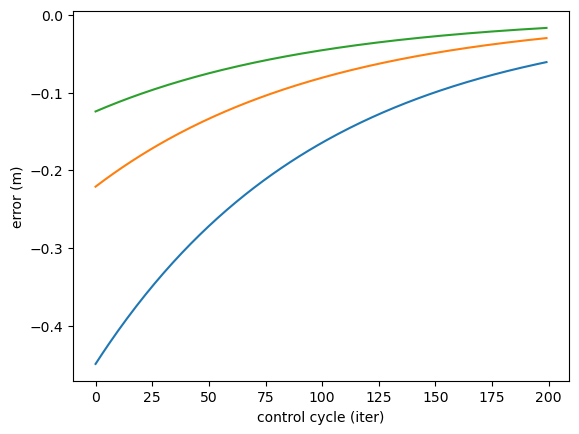

In [23]:
plt.plot(herr)
plt.xlabel('control cycle (iter)')
plt.ylabel('error (m)');

We can observe that each component of the error converges to zero following an exponential trajetory. The convergence is asymptotic. To fasten the convergence, increase the gain of the control law ($v_q = - \lambda J^+ e$), where the gain $\lambda$ was implicitly one so far.

### Place the end effector (6D)
The previous control law brings the center of the effector toward the center of the goal frame. However, it does not control the orientation of the end effector: the axes of the two frames $F_{tool}$ and $F_{goal}$ do not converge.

We now want to modify the control law to take into account both tool translation and tool orientation. For that, let us compute the error in $SE(3)$. We will use the full ${}^{0} J_{tool}$ rather than ${}^o J_{tool3}$, and compute the error vector as the generalized difference between the tool frame and the goal frame:

$$^{tool}M_{goal} = \vphantom{.}^{0}M_{tool}^{-1} \vphantom{.}^{0}M_{goal}$$
$$^{tool}\xi_{goal} = \vphantom{.}^{0}M_{tool} \ominus_{SE(3)} \vphantom{.}^{0}M_{tool} = \log(^{tool}M_{goal})$$
where $^{tool}\xi_{goal}$ is a twist in the local frame.

In [24]:
toolMgoal = oMtool.inverse() * oMgoal
tool_w = pin.log(toolMgoal).vector

This error `tool_w` is can be interpreted as the twist that should be applied during one second to displace the tool frame $F_{tool}$ (located at ${}^0 M_{tool}$) to the goal frame $F_{goal}$ (located at ${}^0 M_{goal}$).

Implement a second control law, following the same pattern as with positions. At each control cycle, you should:

* compute the displacement between $F_{tool}$ and $F_{goal}$, denoted by ``toolMgoal``
* compute the error twist ``tool_w`` using the logarithm over $SE(3)$
* compute the 6D Jacobian `tool_Jtool`
* compute the control law `vq = pinv(J) @ nu`
* integrate the robot velocity `vq` during `DT` to get to a new configuration `q`
* log the error by storing it in a list `herr`.

In [27]:
q = q0.copy()
herr = []
for i in range(200):  # Integrate over 2 second of robot life

    # Run the algorithms that outputs values in robot.data
    pin.framesForwardKinematics(robot.model,robot.data,q)
    pin.computeJointJacobians(robot.model,robot.data,q)

    # Placement from world frame o to frame f oMtool  
    oMtool = robot.data.oMf[IDX_TOOL]

    # 6D error between the two frame
    tool_nu = pin.log(oMtool.inverse()*oMgoal).vector

    # Get corresponding jacobian
    tool_Jtool = pin.computeFrameJacobian(robot.model, robot.data, q, IDX_TOOL)

    # Control law by least square
    vq = pinv(tool_Jtool)@tool_nu

    q = pin.integrate(robot.model,q, vq * DT)
    viz.display(q)
    time.sleep(1e-3)

    herr.append(tool_nu)

The tool frame $F_{tool}$ converges toward the gooal frame $F_{goal}$: the center and the axes are finally aligned. The trajectory of the tool center is not a straight line, as the frame $F_{tool}$ follows a "straight" line, not in $\mathbb{R}^3$ but in $SE(3)$.
We can also plot the error (assuming that herr is a list of the 6D errors herr).

Text(0, 0.5, 'error (rad)')

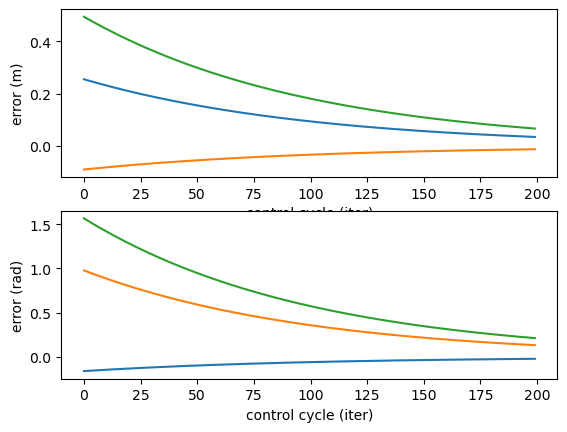

In [28]:
plt.subplot(211)
plt.plot([ e[:3] for e in herr])
plt.xlabel('control cycle (iter)')
plt.ylabel('error (m)')
plt.subplot(212)
plt.plot([ e[3:] for e in herr])
plt.xlabel('control cycle (iter)')
plt.ylabel('error (rad)')

### Inverse kinematics with two tasks

So far we controlled the robot with a single task, either the 3D position or 6D placement of the tool frame. Let's see how to take into account a second task: gaze control.

#### Gaze control

The robot has an additional frame, named $F_{gaze}$, attached to its head and located 40 cm in front of its cameras. The task will be to position (3D) the origin of this frame on an object of interest (a red ball).

In [50]:
robot = loadTiago(addGazeFrame=True)
viz = MeshcatVisualizer(robot)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7002/static/


In [58]:
IDX_GAZE = robot.model.getFrameId('framegaze')

# Add a small ball as a visual target to be reached by the robot
ball = np.array([ 1.2,0.5,1.1 ])
viz.addSphere('ball', .05, [ .8,.1,.5, .8])
viz.applyConfiguration('ball', list(ball)+[0,0,0,1])

# Add the box again
oMgoal = pin.SE3(pin.Quaternion(-0.5, 0.58, -0.39, 0.52).normalized().matrix(), np.array([1.2, .4, .7]))
viz.addBox('goal', [.1,.1,.1], [ .1,.1,.5, .6])
viz.applyConfiguration('goal', oMgoal)

In [59]:
viz.display(q0)

Controlling this point can be done by achieving a simple variation of the control law for positioning (3D) the robot tool:

In [60]:
q = q0.copy()
herr = [] # Log the value of the error between gaze and ball.
# Loop on an inverse kinematics for 200 iterations.
for i in range(200):  # Integrate over 2 second of robot life

    # Run the algorithms that outputs values in robot.data
    pin.framesForwardKinematics(robot.model,robot.data,q)
    pin.computeJointJacobians(robot.model,robot.data,q)

    # Placement from world frame o to frame f oMgaze
    oMgaze = robot.data.oMf[IDX_GAZE]

    # 6D jacobian in local frame
    o_Jgaze3 = pin.computeFrameJacobian(robot.model, robot.data, q, IDX_GAZE,pin.LOCAL_WORLD_ALIGNED)[:3,:]

    # vector from gaze to ball, in world frame
    o_GazeBall = oMgaze.translation-ball
    
    vq = -pinv(o_Jgaze3) @ o_GazeBall

    q = pin.integrate(robot.model,q, vq * DT)
    viz.display(q)
    time.sleep(1e-3)

    herr.append(o_GazeBall) 

#### Multi-tasking

We now have two tasks: $(e_1, J_1)$ for controlling the tool placement, and $(e_2, J_2)$ for controlling the gaze position. We can use the previous derivation to compute the optimal (in a least square sense) control for task 1:
$$
\min_{x\in \mathbb{R}^n} \|J_1 x - v_1^*\|_2^2
$$
with solution:
$$
vq_1 = J_1^+ v_1^*
$$

We may now add to $vq_1$ any vector that lies is in the nullspace of $J_1$ to perform the second task. We thus search for $vq_2 = vq_1 + dvq_2$, where $dvq_2$ gives an optimal control for task 2 while constraining $dvq_2$ is in the nullspace of $J_1$.
$$
\min_{x\in Ker(J_1)} \|J_2 (vq_1 + x) - v_2^*\|_2^2
$$
The orthogonal nullspace projector of $J_1$ can be computed using the pseudoinverse:
$$
P_1 = I_{nq} - J_1^+ J_1
$$
Instead we can solve the problem:
$$
\min_{x\mathbb{R}^n} \|J_2 (vq_1 + P_1 x) - v_2^*\|_2^2
$$
with solution:
$$
dvq_2 = (J_2 P_1)^+ (v_2^* - J_2 vq_1)
$$
Finally, the control law to perform task 1 and task 2 in the nullspace of task 1 is:
$$
vq_2 = J_1^+ v_1^* + (J_2 P_1)^+ ( v_2^* - J_2 J_1^+ v_1^*)
$$

In [62]:
q = q0.copy()
herr = [] # Log the value of the error between tool and goal.
herr2 = [] # Log the value of the error between gaze and ball.
# Loop on an inverse kinematics for 200 iterations.
for i in range(200):  # Integrate over 2 second of robot life

    pin.framesForwardKinematics(robot.model,robot.data,q)
    pin.computeJointJacobians(robot.model,robot.data,q)

    # Gaze task
    oMgaze = robot.data.oMf[IDX_GAZE]
    o_Jgaze3 = pin.computeFrameJacobian(robot.model, robot.data, q, IDX_GAZE,pin.LOCAL_WORLD_ALIGNED)[:3,:]
    o_GazeBall = oMgaze.translation-ball

    # Tool task
    oMtool = robot.data.oMf[IDX_TOOL]
    o_Jtool3 = pin.computeFrameJacobian(robot.model,robot.data,q,IDX_TOOL,pin.LOCAL_WORLD_ALIGNED)[:3,:]
    o_TG = oMtool.translation-oMgoal.translation
    
    vq = -pinv(o_Jtool3) @ o_TG
    Ptool = np.eye(robot.nv)-pinv(o_Jtool3) @ o_Jtool3
    vq += pinv(o_Jgaze3 @ Ptool) @ (-o_GazeBall - o_Jgaze3 @ vq)

    q = pin.integrate(robot.model,q, vq * DT)
    viz.display(q)
    time.sleep(1e-3)

    herr.append(o_TG)
    herr2.append(o_GazeBall) 

Text(0, 0.5, 'error (rad)')

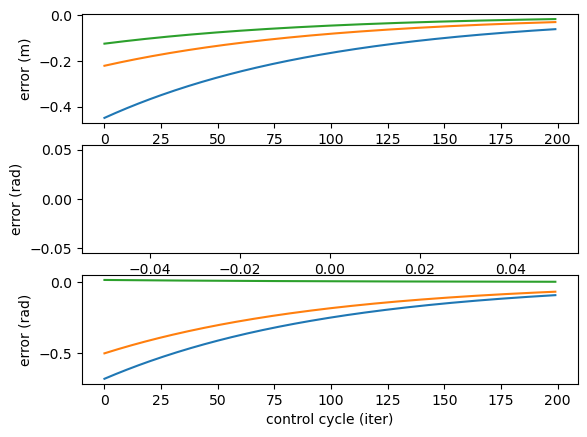

In [64]:
plt.subplot(311)
plt.plot([ e[:3] for e in herr])
plt.xlabel('control cycle (iter)')
plt.ylabel('error (m)')
plt.subplot(312)
plt.plot([ e[3:] for e in herr])
plt.xlabel('control cycle (iter)')
plt.ylabel('error (rad)')
plt.subplot(313)
plt.plot([ e for e in herr2])
plt.xlabel('control cycle (iter)')
plt.ylabel('error (rad)')